# Big Data Processes Exercises - Week 04, <b>*part 1*</b>
# <font color= Pink> Hyperparameter tuning </font>

#### What we will cover in this notebook

<ol>
    <li>Importing packages and libraries</li>
    <li>Loading and examining the dataset</li>
    <li>Target features</li>
    <li>Splitting and Scaling</li>
    <li>Hyperparameter tuning</li>
    <ol>
        <li>GridSearchCV (decision trees)</li>
        <li>RandomSearchCV (decision trees)</li>
        <li>k-fold cross validation for KNN</li>
    </ol>
</ol>

## 1. Importing various libraries

In [1]:
# Libraries to work with the data object
import pandas as pd 
import numpy as np

# libraries to visualize
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image

import graphviz
import pydotplus

# sklearn packages for Decision Tree
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree

# sklearn packages for KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

***
***

## 2. Loading and examining the data

In [2]:
df = pd.read_csv("IBM-Employee-Attrition.csv", delimiter=',')

In [3]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,0,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,0,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,0,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   int64 
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

***
***

## 3. Target features

Last week we worked with two classification models:
- Decision tree
- KNN

As you probably recall, we were trying to predict an employee's attrition based on IBM's synthetic dataset. We chose to train our model using the following features from our dataset:

'EnvironmentSatisfaction', 'JobSatisfaction', 'JobInvolvement', 'YearsAtCompany', 'StockOptionLevel', 'YearsWithCurrManager', 'Age', 'MonthlyIncome', 'YearsInCurrentRole', 'JobLevel', 'TotalWorkingYears'

Our **<font color= purple>first model</font>**, the classification decision tree,  which we named 'clf', had an accuracy of 0.76, i.e., 76% of the time, our model was correct when trying to predict attrition from data in our test-dataset.
For this model, **<font color=purple>we did not specify a max_depth</font>** for the decision tree and thus, Python used the default setting. **<font color=purple>The default setting keeps building the tree until all leaves are pure** </font> (only contain one of the two categories we want to predict). To read more about this, you can look at the documentation here: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

Our **<font color= purple>second model</font>**, which we named 'clf_2' (also a classification decision tree), had an accurady of 0.82. I.e., 82% of the time, this model was correct when trying to predict attrition from data in our test-dataset. As you might recall, we gave the second model two parameters:
- criterion="entropy"
- max_depth=6

Thus, we were able to improve the accuracy of the model from 0.76 to 0.82, just by specifying these two parameters!

### **<font color= turquoise>EXERCISE 1</font>**
Looking at the documentation linked above, can you figure out the default value of the parameter 'criterion'. In other words, what criterion for splitting will Python use, if we do not specify any criterion-parameter (which we didn't do when we made 'clf')?

**Write your answer here:**

- The gini criterion is the default criterion, so that will be picked if we do not specify any criterion-parameter.

In this notebook, we will attempt to improve the accuracy of our classification models by making use of hyperparameter tuning <3

To be able to compare our new results with our old models (bloth classification tress and KNN) from last week - we will reuse the features:

In [5]:
#Create the feature and target variables
#From list of feature(s) 'X', the model will guess/predict the 'y' feature (our target)
X = df[['EnvironmentSatisfaction', 'JobSatisfaction', 'JobInvolvement', 'YearsAtCompany', 'StockOptionLevel', 'YearsWithCurrManager', 'Age', 'MonthlyIncome', 'YearsInCurrentRole', 'JobLevel', 'TotalWorkingYears']].values

y = df['Attrition'].values

***
***

## 4. Splitting and Scaling


Before we go on with hyperparameter tuning, we split our data into a test and train sample. 

In [6]:
#Split data into test and train - 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

We also scale our data so it's consistent and uniform, and therefore easier to process for our models. We use sklearn's StandardScaler that does standardization (not normalization!). Unlike with normalization, where the scaled values fall between 0 and 1, standardized values do not have any fixed minimum or maximum. Instead, standardized values are scaled in such a way that they all have a mean equal to 0 and **standard** deviation equal to 1. It is also a great way to detect outliers aka. if it something deviates too much from the standard.

Good  to remember!
- **Standardisation** - Standardization is a scaling technique that assumes your data conforms to a normal distribution. If a given data attribute is normal or close to normal, this is probably the scaling method to use.
- **Normalisatoin** - Normalization is a scaling technique that does not assume any specific distribution. If your data is not normally distributed, consider normalizing it prior to applying your machine learning algorithm. 

In [7]:
# create a standard scaler object and fit it to the training data
scaler = StandardScaler()
scaler.fit(X_train)

# transform the training and test data using the scaler
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

### **<font color=turquoise>EXERCISE 2</font>**
Recap from week 3:
- What is the purpose of splitting the dataset into test and train?
- Why do we scale the data?
- Why are we only scaling X_train and X_test and not y_train and y_test?

**Your answer goes here:**

- To leave out some data that the model can be asseded upon at a later stage.
- The ensure that the data normally distributed. It ensure a fixed range of the data, and therefore handles varying magnitudes.
- Because the y_train and y_test are the target vectors; these are the actual values.

***
***

## 5. Hyperparameter tuning

Now, we get to the hyperparameter tuning! We will be trying out two ways for finding optimal parameters or decision trees: **GridSearch** (5.1) and  **Random Search** (5.2)

But before me move on let's back up for a second. So far, we have looked at two classification models:
- Decision trees
- KNN

As touched upon in section 3 of this notebook, when we train these models, we can choose to specify different parameters, for instance:
- depth (for decision trees)
- k = the number of neighbours (for KNN models)

As we learned last week, the classification performance of our model is affected by the value of these parameters (if you are unsure how, take a look at the KNN visualization in the notebook from week 3).

Thus, we can optimize model accuracy score through hyperparameter tuning. Hyperparameter tuning entails finding optimal values for parameters such as k (in KNN models) and depth (in decision tree models). We do hyperparameter tuning because providing better/optimal parameters when training our models will help us increase the accuracy of these models. 

So, to sum up, **we will be doing hyperparameter tuning when we try to find the optimal k (for KNN classification models) or the optimal depth (for decision tree classification models)**

Hopefully, hyperparamter tuning will allow us to reach a better accuracy than that of our previous decision tree model, clf and clf_2 (see the notebook from week 3 on classification)

### 5.1 GridSearch: finding the optimal max_depth (and more) for a decision tree

One way to find the optimal parameters for a decision tree is using GridSearchCV. 

When performing a GridSearch, we start by specifying the parameters, we want to optimize. In the we will be going through in this notebook, we are trying to find the optimal value for three decisiom tree parameters:
- max_depth
- min_samples_split
- min_sample_leaf

Before we move on, we'll explain what these parameters mean in turn. We will be using decision tree terminology, so if you have trouble understanding what is meant by nodes, branches, depth etc. is, take a look at this illustration first. The model pictured in the image is a tree of depth 2:

![image.png](decision_tree.png)

**max_depth recap:**<br>
We already touched on this parameter in the lecture for week 3. To recap, the max_depth parameter in decision trees controls how deep the tree can grow during the training process. Setting a low max_depth can help prevent overfitting, but it might also miss some patterns in the data. On the other hand, setting a higher max_depth can capture more complex patterns, but it might also lead to overfitting. So, it's a trade-off between complexity and performance.

**min_samples_split explained:**<br>
The min_samples_split hyperparameter determines the minimum number of samples required to split an internal node in a decision tree.
<br>
Imagine you have a decision tree. When building this tree, at each step, it decides whether to split a node into smaller nodes. min_samples_split is like a rule for the tree. It says, "Don't split a node unless you have at least this many samples in it."
<br>
So, if min_samples_split is set to 5, it means that the decision tree won't split a node unless it has at least 5 samples in it. If there are fewer than 5 samples, the node won't split, and it becomes a leaf node in the tree.
<br>
Adjusting min_samples_split can affect how the decision tree is built. A smaller value might lead to a more complex tree with more splits, while a larger value might lead to a simpler tree with fewer splits.

**min_samples_leaf explained:**<br>
The min_samples_leaf hyperparameter specifies the minimum number of samples required to be at a leaf node in a decision tree.
<br>
Imagine you have a decision tree. When building this tree, at each step, it decides whether to keep splitting nodes or stop and declare them as leaf nodes. min_samples_leaf is like a rule for the tree. It says, "Stop splitting a node if, after the split, each resulting leaf node would have at least this many samples."
<br>
So, if min_samples_leaf is set to 5, it means that the decision tree won't continue splitting a node if any resulting leaf node would have fewer than 5 samples. It helps prevent the tree from creating leaf nodes with very few samples, which could lead to overfitting.
Adjusting min_samples_leaf can affect the depth and complexity of the decision tree. A smaller value might lead to a deeper tree with more splits, while a larger value might lead to a shallower tree with fewer splits.



After specifying the parameters we want to optimize, we also define the range within we want to search. For instance, we can define the range of max_depth to be from 2 to 51. Doing this, we ask GridSearch to find the optimal depth within this range.

You can read more on GridSearch in the documentation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

Now, we are ready to perform the GridSearch:

In [8]:
#import GridSearchCV
from sklearn.model_selection import GridSearchCV

In [9]:
#define the type model you want to optimize (we choose decision tree)
dt = DecisionTreeClassifier(random_state=42)

In [10]:
#define lists specifying the range og values we want to test
max_depth = list(range(2, 51))
min_split = list(range(2, 10))
min_leaf = list(range(1, 10))

In [11]:
# Define the hyperparameters to tune
param_grid = {
    'max_depth': max_depth,
    'min_samples_split': min_split,
    'min_samples_leaf': min_leaf,
}

In [12]:
# Create the GridSearchCV object
# Cross-validation
grid_search = GridSearchCV(dt, param_grid, scoring='accuracy', cv=5)

In [13]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                       14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                                       24, 25, 26, 27, 28, 29, 30, 31, ...],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9]},
             scoring='accuracy')

### **<font color=turquoise>EXERCISE 3</font>**
The code cell above will likely take a while to run. Why might that be?<br>
Hint: it has something to do with what the GridSearch is doing "under the hood"

**Type in your answer here:**

Since Grid-search is used to find the optimal hyperparameters of a model which results in the most ‘accurate’ predictions, this means that we will try every combination (training) of the `max_depth`, `min_samples_split` and `min_samples_leaf`, which in computationally expensive.

In [15]:
#here we ask GridSearch to give us the optimal value of the three parameters
grid_search.best_params_

{'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 7}

It is important to note that, '.best_params_' doesn’t show the overall best parameters, but rather the best parameters of **the range we passed in** to our search.

Anyway - having found the best parameters for our model, we can now try to make a new decision tree, 'clf_3', which (hopefully) is even more accurate than our previous models, 'clf' and 'clf_2'...

In [16]:
#making a new classifier using hyperparameter tuning
clf_3 = DecisionTreeClassifier(max_depth=4, min_samples_leaf=3, min_samples_split=7, random_state=42)

In [17]:
#training the model on our data
clf_3.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=3, min_samples_split=7,
                       random_state=42)

In [19]:
#predicting...
y_pred = clf_3.predict(X_test)

In [20]:
#calculating the accuracy of our new model...
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))

Accuracy:  0.8333333333333334


As you can see, GridSearch/hyperparameter tuning helped us to increase the accuracy of our decision tree even further!
- clf ~ 75% accurate
- clf_2 ~ 82% accurate
- clf_3 ~ 83% accurate

In [21]:
#below, we print number of correct and incorrect predictions
mtr = confusion_matrix(y_test, y_pred)

print("Correct predictions:", (mtr[0,0] + mtr[1,1]))
print("Incorrect predictions:", (mtr[0,1] + mtr[1,0]))
print("Total predictions:", (mtr.sum()))

Correct predictions: 245
Incorrect predictions: 49
Total predictions: 294


Now, lets visualize our new classification tree! <font color=red>(If it doesn't work, no worries, just move on to the next cell!)</font>

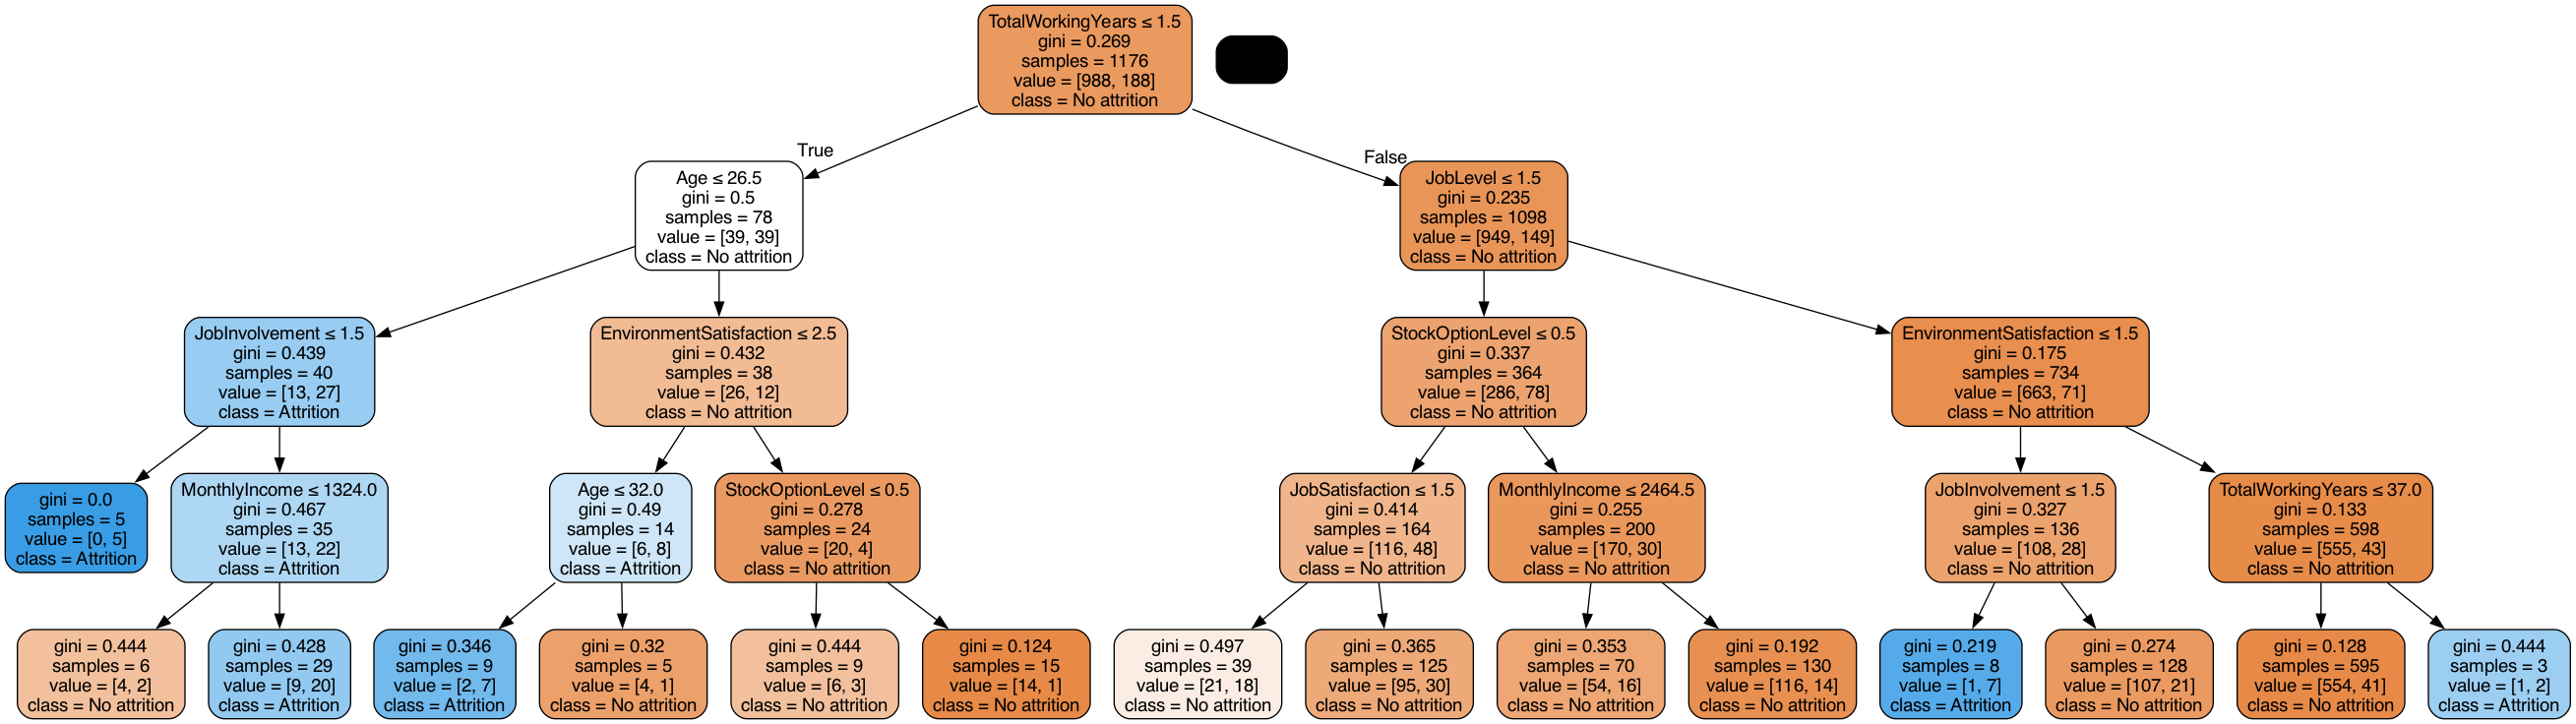

In [22]:
feature_names = ['EnvironmentSatisfaction', 'JobSatisfaction', 'JobInvolvement', 'YearsAtCompany', 'StockOptionLevel', 'YearsWithCurrManager', 'Age', 'MonthlyIncome', 'YearsInCurrentRole', 'JobLevel', 'TotalWorkingYears']

#Creating a StringIO object called dot_data to hold the text representation of the decision tree.
dot_data = StringIO()

export_graphviz(clf_3, out_file = dot_data,  
                filled = True, rounded = True,
                special_characters = True, feature_names = feature_names, class_names=['No attrition','Attrition'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

#Saving the tree as .png
graph.write_png('Attrition.png')
Image(graph.create_png())

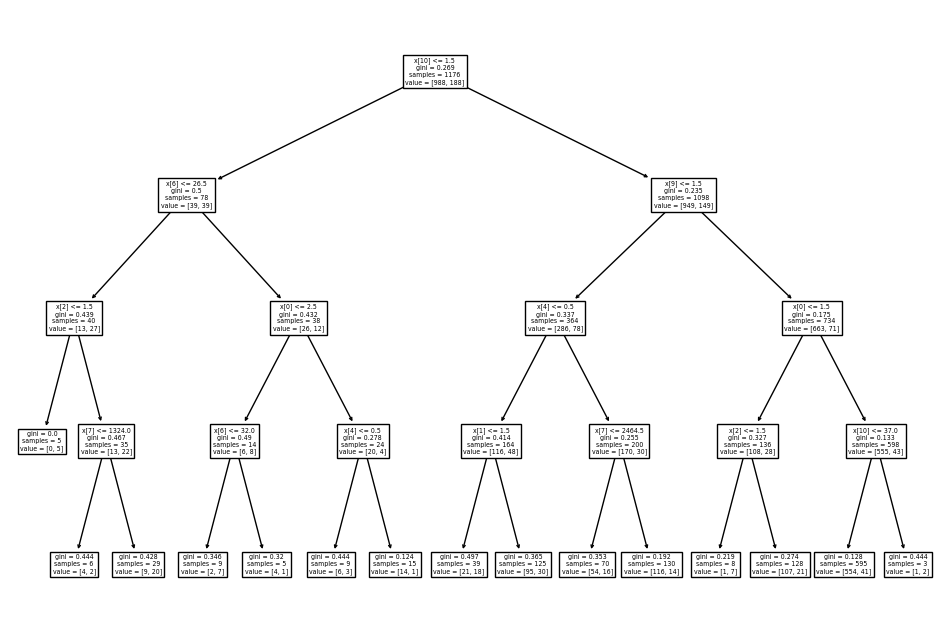

In [23]:
#alternative way to plot our new tree
plt.figure(figsize=(12,8))
tree.plot_tree(clf_3.fit(X_train, y_train))
plt.show()

### **<font color=turquoise>EXERCISE 4</font>**
Open the notebook from week 3 ('BDP_Classification') and compare the visualization of 'clf_3' to the visualizations of 'clf' (section 5.2.1) and 'clf_2' (section 5.2.2). Describe in your own words how these models differ.<br>
For each tree, define its depth.

**Your answer goes here:**

- `clf`: This model overfits to the data by choosing a depth of 17.
- `clf_2`: Here, we restrict the model to have a depth of 6.
- `clf_3`: We find the optimal depth of 4.

### 5.2 RandomSearch: another way of finding the optimal max_depth (and more) for a decision tree


RandomSearch is another hyperparameter optimization technique similar to GridSearch, with one key difference: instead of searching over a predefined grid of hyperparameter values, RandomSearch samples hyperparameter values randomly from specified interval/range.

Thus, below, we define a search space as a bounded domain of hyperparameter values and randomly sample points in that domain.

In [24]:
from sklearn.model_selection import RandomizedSearchCV

In [25]:
max_depth = [5, 10, 20, 30, 40, 50]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
        
random_grid = {'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [26]:
rs = RandomizedSearchCV(dt, random_grid, scoring='accuracy', cv=5)

In [27]:
rs.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
                   param_distributions={'max_depth': [5, 10, 20, 30, 40, 50],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10]},
                   scoring='accuracy')

In [28]:
#find the optimal values for the parameters
rs.best_params_

{'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 5}

In [29]:
# here, we make yet another classifier with the new parameter values
clf_4 = DecisionTreeClassifier(max_depth=10, min_samples_leaf=1, min_samples_split=10, random_state=42)

In [30]:
# training the model
clf_4.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_split=10, random_state=42)

In [31]:
# predicting...
y_pred = clf_4.predict(X_test)

In [32]:
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))

Accuracy:  0.8095238095238095


As you can see, we got an accuracy of approximately 83%, pretty close to that of clf_3.

In [33]:
# All your burning questions about the confusion matrix will have to wait until week 5:)) 
# We use it here to illustrate the number of correct and incorrect predictions
mtr = confusion_matrix(y_test, y_pred)

print("Correct predictions:", (mtr[0,0] + mtr[1,1]))
print("Incorrect predictions:", (mtr[0,1] + mtr[1,0]))
print("Total predictions:", (mtr.sum()))

Correct predictions: 238
Incorrect predictions: 56
Total predictions: 294


Now, lets visualize our new classification tree! <font color=red>(If it doesn't work, no worries, just move on to the next cell!)</font>

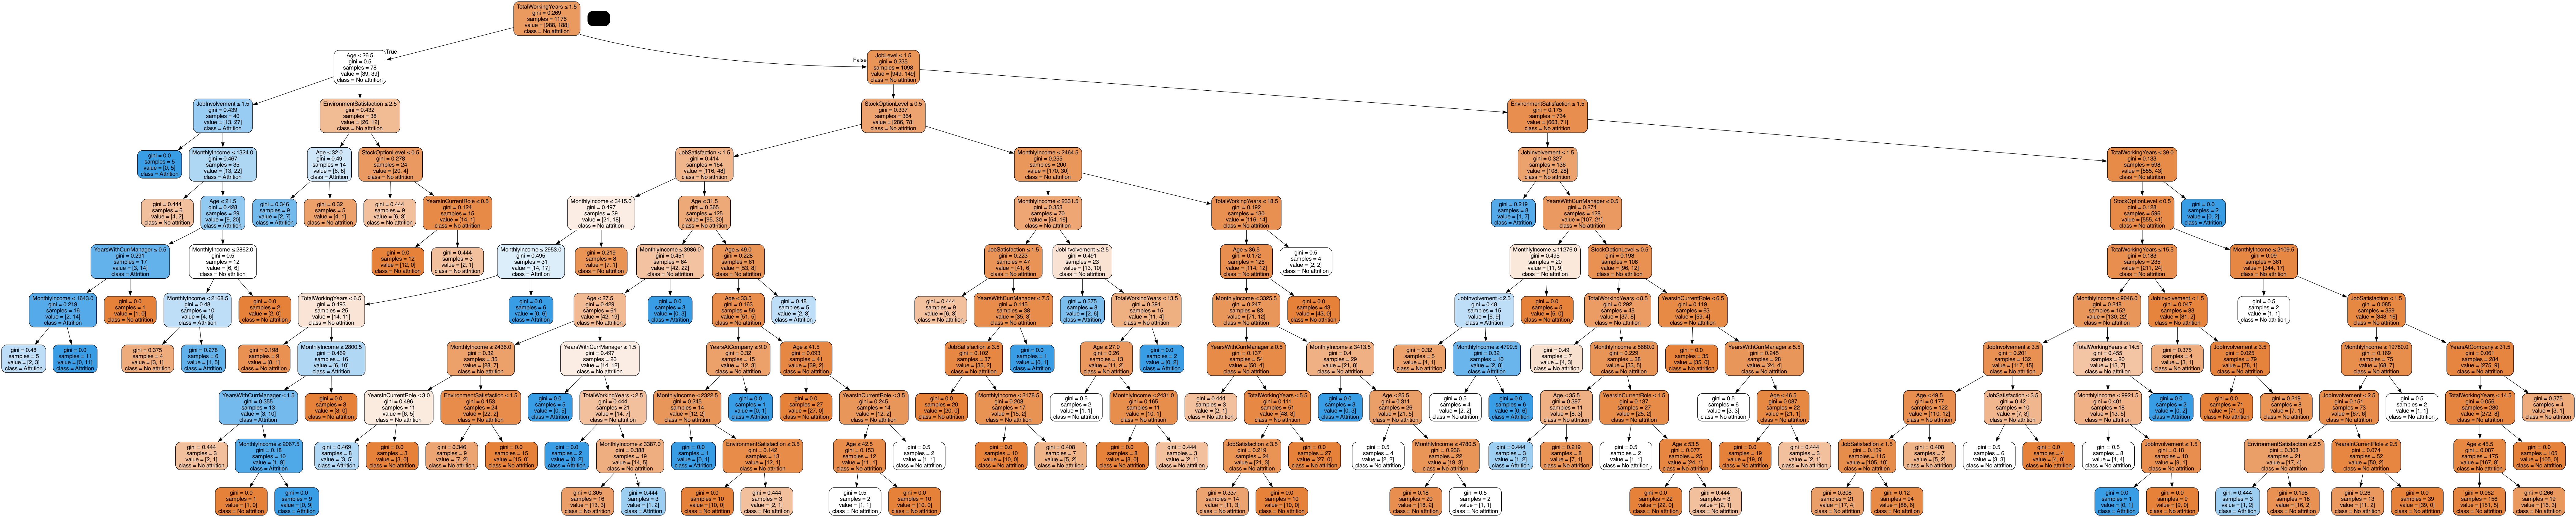

In [34]:
feature_names = ['EnvironmentSatisfaction', 'JobSatisfaction', 'JobInvolvement', 'YearsAtCompany', 'StockOptionLevel', 'YearsWithCurrManager', 'Age', 'MonthlyIncome', 'YearsInCurrentRole', 'JobLevel', 'TotalWorkingYears']

#Creating a StringIO object called dot_data to hold the text representation of the decision tree.
dot_data = StringIO()

export_graphviz(clf_4, out_file = dot_data,  
                filled = True, rounded = True,
                special_characters = True, feature_names = feature_names, class_names=['No attrition','Attrition'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

#Saving the tree as .png
graph.write_png('Attrition.png')
Image(graph.create_png())

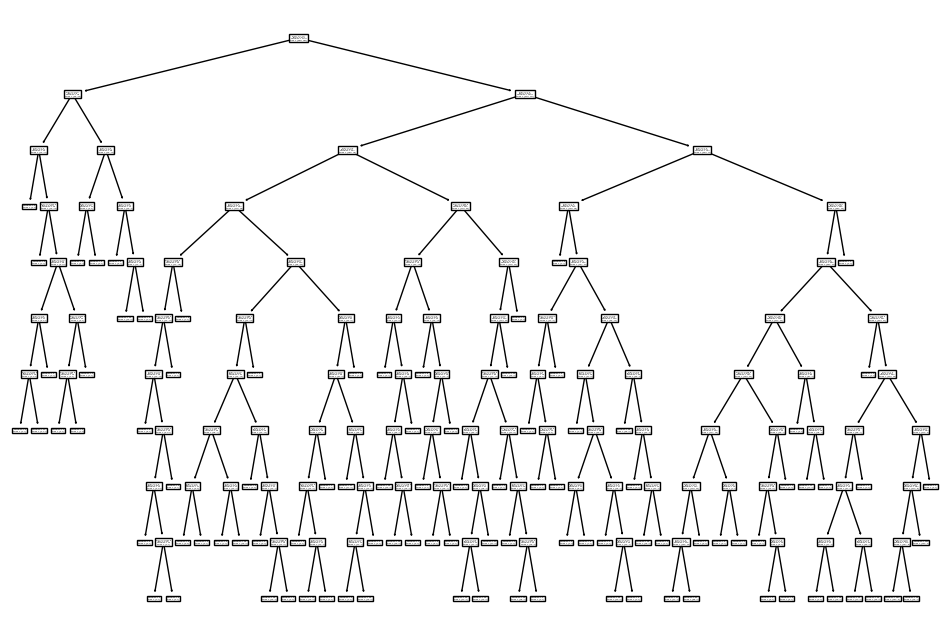

In [36]:
plt.figure(figsize=(12,8))
tree.plot_tree(clf_4.fit(X_train, y_train))
plt.show()

### 5.3 k-fold cross validation for KNN - finding the optimal k-number of neighbours


Now, we'll try to find the optimal k for our KNN model. As you might remember, we made a KNN classification model without specifying a number of neighbours. Thus, the model used the default number of neighbours, 5.

The model had an accuracy of 0.83 - so, in 83% of the time, the model was correct.

Let's see if we can improve that with some hyperparameter tuning!

Below, we use k-fold cross-validation to find the optimal k in our KNN classifier. 
More specifically, we iterate through different values of k, apply k-fold cross-validation for each value, and then select the k value that gives the highest average accuracy across all folds.

In [37]:
# set up k-NN classifier with cross-validation to find the optimal value of k
# we have chosen to search for k in the range from 1-15
cv_scores = []

for k in range(1, 15):
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_std, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Find the optimal value of k
optimal_k = np.argmax(cv_scores) + 1
print("The optimal number of neighbors is %d" % optimal_k)

The optimal number of neighbors is 11


k-fold cross-validation with ✨ visualisation ✨

/Users/simonskodt/anaconda3/envs/iml/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/simonskodt/anaconda3/envs/iml/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/simonskodt/anaconda3/envs/iml/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/simonskodt/anaconda3/envs/iml/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

Text(0, 0.5, 'Accuracy Score')

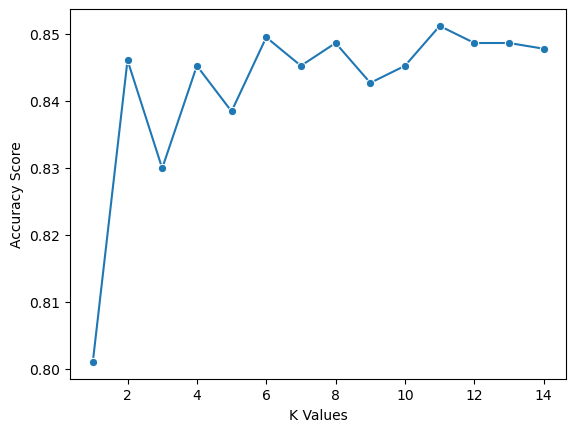

In [38]:
k_values = [i for i in range (1,15)]
scoresByK = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_train_std, y_train, cv=5)
    scoresByK.append(score.mean())

sns.lineplot(x = k_values, y = scoresByK, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

In [39]:
model_KNN = KNeighborsClassifier(n_neighbors=11)

In [40]:
# fit the classifier to the standardized training data, tilpasser den data vi har, så den passer til den model vi gerne vil lave, her KNN
model_KNN.fit(X_train_std, y_train)

# predict the class labels for the standardized test data
y_pred = model_KNN.predict(X_test_std)

In [41]:
# evaluate the performance of the classifier using the accuracy score
accuracy_test_KNN = round(model_KNN.score(X_test_std, y_test),4)
accuracy_test_KNN

0.8435

As you can see, we managed to improve the model from an accuracy of 0.83 to approximately 0.84. Well done!

***
***
***
# Take home messages

After finishing this notebook, you should know:
- How to perform hyperparameter tuning for decision trees and KNN models
- Understand what the k and max_depth parameters refer to and why it makes sense to optimize them
